# All oscillation analysis

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import collections
import itertools
from collections import defaultdict
from itertools import combinations

In [3]:
os.environ["SPECTRAL_CONNECTIVITY_ENABLE_GPU"] = "true"
import cupy as cp

In [4]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mannwhitneyu


In [5]:
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import colorsys

In [6]:
from sklearn.metrics import confusion_matrix

In [7]:
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [8]:
FONTSIZE = 20

In [9]:
font = {'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

# Functions

In [10]:
def generate_pairs(lst):
    """
    Generates all unique pairs from a list.

    Parameters:
    - lst (list): The list to generate pairs from.

    Returns:
    - list: A list of tuples, each containing a unique pair from the input list.
    """
    n = len(lst)
    return [(lst[i], lst[j]) for i in range(n) for j in range(i+1, n)]

In [11]:
def update_array_by_mask(array, mask, value=np.nan):
    """
    """
    result = array.copy()
    result[mask] = value
    return result

## Inputs & Data

Explanation of each input and where it comes from.

In [12]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

In [13]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5
RESAMPLE_RATE=1000

In [14]:
zscore_threshold = 4
VOLTAGE_SCALING_VALUE = 0.195

In [15]:
BAND_TO_FREQ = {"theta": (4,12), "gamma": (30,51)}

In [16]:
OUTPUT_PREFIX = "rce_pilot_3_alone_comp"

In [17]:
LFP_TRACES_DF = pd.read_pickle("./proc/{}_01_lfp_traces_and_frames.pkl".format(OUTPUT_PREFIX))

In [18]:
LFP_TRACES_DF.shape

(28, 24)

## Preprocessing

In [19]:
original_trace_columns = [col for col in LFP_TRACES_DF.columns if "trace" in col]

In [20]:
original_trace_columns

['vHPC_lfp_trace',
 'BLA_lfp_trace',
 'LH_lfp_trace',
 'MD_lfp_trace',
 'mPFC_lfp_trace']

In [21]:
for col in original_trace_columns:
    print(col)
    LFP_TRACES_DF[col] = LFP_TRACES_DF[col].apply(lambda x: x.astype(np.float32) * VOLTAGE_SCALING_VALUE)

vHPC_lfp_trace
BLA_lfp_trace
LH_lfp_trace
MD_lfp_trace
mPFC_lfp_trace


In [22]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,notes,session_path,recording,current_subject,...,video_timestamps,tone_timestamps,box_1_port_entry_timestamps,box_2_port_entry_timestamps,lfp_timestamps,vHPC_lfp_trace,BLA_lfp_trace,LH_lfp_trace,MD_lfp_trace,mPFC_lfp_trace
0,NaN,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[1384, 2770, 4156, 4156, 5542, 6928, 6928, 831...","[[0, 75474], [1275889, 1475891], [3275911, 347...","[[0, 75474], [153075, 158874], [252873, 306276...","[[0, 75474], [162074, 226073], [255076, 258076...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[75.465, 134.355, 124.799995, 63.374996, 101.5...","[62.01, 111.149994, 97.5, 50.114998, 96.524994...","[62.204998, 108.615, 94.575, 44.07, 83.85, 94....","[64.35, 99.255, 82.875, 49.92, 98.67, 102.765,...","[72.735, 125.189995, 118.56, 86.774994, 139.62..."
1,NaN,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[1332, 1384, 2770, 4156, 5267, 5542, 6928, 831...","[[0, 75474], [1275889, 1475891], [3275911, 347...","[[0, 75474], [153075, 158874], [252873, 306276...","[[0, 75474], [162074, 226073], [255076, 258076...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[75.465, 134.355, 124.799995, 63.374996, 101.5...","[62.01, 111.149994, 97.5, 50.114998, 96.524994...","[62.204998, 108.615, 94.575, 44.07, 83.85, 94....","[64.35, 99.255, 82.875, 49.92, 98.67, 102.765,...","[72.735, 125.189995, 118.56, 86.774994, 139.62..."
2,NaN,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[1384, 2770, 4156, 4156, 5542, 6928, 6928, 831...","[[0, 75474], [1275889, 1475891], [3275911, 347...","[[0, 75474], [153075, 158874], [252873, 306276...","[[0, 75474], [162074, 226073], [255076, 258076...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[-20.474998, -4.68, 21.644999, 28.079998, 23.7...","[13.844999, 53.82, 88.53, 85.409996, 96.91499,...","[0.0, 28.47, 67.079994, 70.784996, 70.784996, ...","[3.3149998, 38.805, 69.03, 67.47, 81.704994, 1...","[-38.805, -20.085, 2.73, 11.309999, 28.47, 64...."
3,NaN,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[1332, 1384, 2770, 4156, 5267, 5542, 6928, 831...","[[0, 75474], [1275889, 1475891], [3275911, 347...","[[0, 75474], [153075, 158874], [252873, 306276...","[[0, 75474], [162074, 226073], [255076, 258076...","[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 2...","[-20.474998, -4.68, 21.644999, 28.079998, 23.7...","[13.844999, 53.82, 88.53, 85.409996, 96.91499,...","[0.0, 28.47, 67.079994, 70.784996, 70.784996, ...","[3.3149998, 38.805, 69.03, 67.47, 81.704994, 1...","[-38.805, -20.085, 2.73, 11.309999, 28.47, 64...."
4,NaN,20240320_171038_alone_comp_subj_4-2_and_4-3,"[[0, 79], [1276, 1477], [3272, 3473], [4470, 4...","[[0, 79], [84, 92], [92, 132], [145, 17

# Calculating modified zscore

`0.6745(xi – x̃) / MAD`

In [23]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_MAD".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: stats.median_abs_deviation(x))

vHPC_lfp_trace
BLA_lfp_trace
LH_lfp_trace
MD_lfp_trace
mPFC_lfp_trace


In [24]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_modified_zscore".format(brain_region)
    MAD_column = "{}_lfp_MAD".format(brain_region)

    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF.apply(lambda x: 0.6745 * (x[col] - np.median(x[col])) / x[MAD_column], axis=1)

vHPC_lfp_trace
BLA_lfp_trace
LH_lfp_trace
MD_lfp_trace
mPFC_lfp_trace


In [25]:
LFP_TRACES_DF[updated_column]

0     [0.74413866, 1.2793614, 1.2117124, 0.88739526,...
1     [0.74413866, 1.2793614, 1.2117124, 0.88739526,...
2     [-0.2906841, -0.15521966, 0.009877616, 0.07196...
3     [-0.2906841, -0.15521966, 0.009877616, 0.07196...
4     [0.024630615, -0.43766713, -0.66123736, -0.689...
5     [0.024630615, -0.43766713, -0.66123736, -0.689...
6     [0.14578532, 0.297402, -0.1399539, -0.56370324...
7     [0.14578532, 0.297402, -0.1399539, -0.56370324...
8     [-0.3882878, 0.09206825, 0.15211275, -0.506375...
9     [-0.3882878, 0.09206825, 0.15211275, -0.506375...
10    [-0.5509115, -0.8881615, 0.029326085, 0.804372...
11    [-0.5509115, -0.8881615, 0.029326085, 0.804372...
12    [-0.6099, -0.80939996, -0.6707, -0.39139998, -...
13    [-0.6099, -0.80939996, -0.6707, -0.39139998, -...
14    [-0.60751194, -0.5821027, -0.3257003, -0.02078...
15    [-0.60751194, -0.5821027, -0.3257003, -0.02078...
16    [-1.3656029, -1.3822061, -0.97958153, -0.36526...
17    [-1.3656029, -1.3822061, -0.97958153, -0.3

## calculating root mean sequare

In [26]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_RMS".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: (x / np.sqrt(np.mean(x**2))).astype(np.float32))


vHPC_lfp_trace
BLA_lfp_trace
LH_lfp_trace
MD_lfp_trace
mPFC_lfp_trace


In [27]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,notes,session_path,recording,current_subject,...,vHPC_lfp_modified_zscore,BLA_lfp_modified_zscore,LH_lfp_modified_zscore,MD_lfp_modified_zscore,mPFC_lfp_modified_zscore,vHPC_lfp_RMS,BLA_lfp_RMS,LH_lfp_RMS,MD_lfp_RMS,mPFC_lfp_RMS
0,NaN,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[0.7310223, 1.300014, 1.207694, 0.6142095, 0.9...","[0.6501205, 1.1620903, 1.0198765, 0.52619123, ...","[0.63669616, 1.1102389, 0.96698236, 0.45165634...","[0.6605723, 1.0167242, 0.8495915, 0.5133363, 1...","[0.74413866, 1.2793614, 1.2117124, 0.88739526,...","[0.69433415, 1.236166, 1.1482528, 0.58309716, ...","[0.6303827, 1.1299312, 0.9911678, 0.5094602, 0...","[0.6189879, 1.0808034, 0.94109446, 0.43853062,...","[0.6432096, 0.992102, 0.828376, 0.49897468, 0....","[0.7264124, 1.2502861, 1.1840717, 0.8666313, 1..."
1,NaN,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[0.7310223, 1.300014, 1.207694, 0.6142095, 0.9...","[0.6501205, 1.1620903, 1.0198765, 0.52619123, ...","[0.63669616, 1.1102389, 0.96698236, 0.45165634...","[0.6605723, 1.0167242, 0.8495915, 0.5133363, 1...","[0.74413866, 1.2793614, 1.2117124, 0.88739526,...","[0.69433415, 1.236166, 1.1482528, 0.58309716, ...","[0.6303827, 1.1299312, 0.9911678, 0.5094602, 0...","[0.6189879, 1.0808034, 0.94109446, 0.43853062,...","[0.6432096, 0.992102, 0.828376, 0.49897468, 0....","[0.7264124, 1.2502861, 1.1840717, 0.8666313, 1..."
2,NaN,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[-0.16099176, -0.048575103, 0.13878599, 0.1845...","[0.09494012, 0.38542855, 0.6376576, 0.6149853,...","[-0.008537974, 0.19921939, 0.48097253, 0.50800...","[0.015425156, 0.2706414, 0.48799583, 0.4767775...","[-0.2906841, -0.15521966, 0.009877616, 0.07196...","[-0.10348419, -0.02365353, 0.109397575, 0.1419...","[0.0727714, 0.28288603, 0.46532702, 0.44892782...","[0.0, 0.15239632, 0.35907075, 0.37890315, 0.37...","[0.017063027, 0.1997378, 0.35531247, 0.3472828...","[-0.20107095, -0.10407189, 0.014145696, 0.0586..."
3,NaN,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[-0.16099176, -0.048575103, 0.13878599, 0.1845...","[0.09494012, 0.38542855, 0.6376576, 0.6149853,...","[-0.008537974, 0.19921939, 0.48097253, 0.50800...","[0.015425156, 0.2706414, 0.48799583, 0.4767775...","[-0.2906841, -0.15521966, 0.009877616, 0.07196...","[-0.10348419, -0.02365353, 0.109397575, 0.1419...","[0.0727714, 0.28288603, 0.46532702, 0.44892782...","[0.0, 0.15239632, 0.35907075, 0.37890315, 0.37...","[0.017063027, 0.1997378, 0.35531247, 0.3472828...","[-0.20107095, -0.10407189, 0.014145696, 0.0586..."
4,NaN,20240320_171038_alone_comp_subj_4-2_and_4-3,"[[0, 79], [1276, 1477], [3272, 3473], [4470, 4...","[[0, 79], [84, 92], [92, 132], [1

## Filtering for zscore value

In [28]:
zscore_columns = [col for col in LFP_TRACES_DF.columns if "zscore" in col]

In [29]:
zscore_columns

['vHPC_lfp_modified_zscore',
 'BLA_lfp_modified_zscore',
 'LH_lfp_modified_zscore',
 'MD_lfp_modified_zscore',
 'mPFC_lfp_modified_zscore']

In [30]:
for col in zscore_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_mask".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: np.abs(x) >= zscore_threshold)

vHPC_lfp_modified_zscore
BLA_lfp_modified_zscore
LH_lfp_modified_zscore
MD_lfp_modified_zscore
mPFC_lfp_modified_zscore


In [31]:
LFP_TRACES_DF[updated_column].head()

0    [False, False, False, False, False, False, Fal...
1    [False, False, False, False, False, False, Fal...
2    [False, False, False, False, False, False, Fal...
3    [False, False, False, False, False, False, Fal...
4    [False, False, False, False, False, False, Fal...
Name: mPFC_lfp_mask, dtype: object

In [32]:
LFP_TRACES_DF[updated_column].iloc[0].shape

(3179713,)

In [33]:
sum(LFP_TRACES_DF[updated_column].iloc[0])

930

- Filtering raw traces by zscore

In [34]:
LFP_TRACES_DF[col].head()

0    [0.74413866, 1.2793614, 1.2117124, 0.88739526,...
1    [0.74413866, 1.2793614, 1.2117124, 0.88739526,...
2    [-0.2906841, -0.15521966, 0.009877616, 0.07196...
3    [-0.2906841, -0.15521966, 0.009877616, 0.07196...
4    [0.024630615, -0.43766713, -0.66123736, -0.689...
Name: mPFC_lfp_modified_zscore, dtype: object

In [35]:
for col in original_trace_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_trace_filtered".format(brain_region)    
    mask_column = "{}_lfp_mask".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF.apply(lambda x: update_array_by_mask(x[col], x[mask_column]), axis=1)

vHPC_lfp_trace
BLA_lfp_trace
LH_lfp_trace
MD_lfp_trace
mPFC_lfp_trace


In [36]:
LFP_TRACES_DF[col].head()

0    [72.735, 125.189995, 118.56, 86.774994, 139.62...
1    [72.735, 125.189995, 118.56, 86.774994, 139.62...
2    [-38.805, -20.085, 2.73, 11.309999, 28.47, 64....
3    [-38.805, -20.085, 2.73, 11.309999, 28.47, 64....
4    [0.78, -46.8, -69.81, -72.735, -126.74999, -16...
Name: mPFC_lfp_trace, dtype: object

In [37]:
sum(np.isnan(LFP_TRACES_DF[col].iloc[0]))

0

- Calculating RMS of filtered signal

In [38]:
filtered_trace_column = [col for col in LFP_TRACES_DF if "lfp_trace_filtered" in col]

In [39]:
for col in filtered_trace_column:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_lfp_RMS_filtered".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: (x / np.sqrt(np.nanmean(x**2))).astype(np.float32))

vHPC_lfp_trace_filtered
BLA_lfp_trace_filtered
LH_lfp_trace_filtered
MD_lfp_trace_filtered
mPFC_lfp_trace_filtered


# Power Calcuation

- Getting the column name of all the traces

In [40]:
input_columns = [col for col in LFP_TRACES_DF.columns if "RMS" in col and "filtered" in col]

In [41]:
input_columns

['vHPC_lfp_RMS_filtered',
 'BLA_lfp_RMS_filtered',
 'LH_lfp_RMS_filtered',
 'MD_lfp_RMS_filtered',
 'mPFC_lfp_RMS_filtered']

In [42]:
for col in input_columns:
    print(col)
    LFP_TRACES_DF[col] = LFP_TRACES_DF[col].apply(lambda x: np.round(x.astype(np.float32), decimals=3))

vHPC_lfp_RMS_filtered
BLA_lfp_RMS_filtered
LH_lfp_RMS_filtered
MD_lfp_RMS_filtered
mPFC_lfp_RMS_filtered


- Calcuating the power at each frequency band

In [43]:
LFP_TRACES_DF[col].iloc[0]

array([ 0.736,  1.267,  1.2  , ..., -0.442, -0.489, -0.29 ], dtype=float32)

In [44]:
for col in input_columns:
    # brain_region = col.split("_")[0]
    brain_region = col.replace("_lfp", "")
    print(brain_region)

    # Define column names
    multitaper_col = f"{brain_region}_power_multitaper"
    connectivity_col = f"{brain_region}_power_connectivity"
    frequencies_col = f"{brain_region}_power_frequencies"
    power_col = f"{brain_region}_power_all_frequencies_all_windows"
    
    try:
        # Apply Multitaper function to the lfp_trace column
        LFP_TRACES_DF[multitaper_col] = LFP_TRACES_DF[col].apply(
            lambda x: Multitaper(
                time_series=x, 
                sampling_frequency=RESAMPLE_RATE, 
                time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT,
                time_window_duration=TIME_WINDOW_DURATION, 
                time_window_step=TIME_WINDOW_STEP
            )
        )

        # Apply Connectivity function to the multitaper column
        LFP_TRACES_DF[connectivity_col] = LFP_TRACES_DF[multitaper_col].apply(
            lambda x: Connectivity.from_multitaper(x)
        )

        # Apply frequencies and power functions to the connectivity column
        LFP_TRACES_DF[frequencies_col] = LFP_TRACES_DF[connectivity_col].apply(
            lambda x: x.frequencies
        )
        LFP_TRACES_DF[power_col] = LFP_TRACES_DF[connectivity_col].apply(
            lambda x: x.power().squeeze()
        )
        
        LFP_TRACES_DF[power_col] = LFP_TRACES_DF[power_col].apply(lambda x: x.astype(np.float32))
            
        # Removing unnecessary columns
        LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[multitaper_col, connectivity_col], errors="ignore")
    
    except Exception as e: 
        print(e)

vHPC_RMS_filtered
BLA_RMS_filtered
LH_RMS_filtered
MD_RMS_filtered
mPFC_RMS_filtered


- Getting the timestamps of the power

In [45]:
LFP_TRACES_DF["power_timestamps"] = LFP_TRACES_DF["lfp_timestamps"].apply(lambda x: x[(RESAMPLE_RATE//2):(-RESAMPLE_RATE//2):(RESAMPLE_RATE//2)])
# .iloc[0][500:-500:500].shape

- Making sure that the timestamps for power makes sense with shape and values

In [46]:
LFP_TRACES_DF["power_timestamps"].head().apply(lambda x: x.shape)

0    (6358,)
1    (6358,)
2    (6358,)
3    (6358,)
4    (6437,)
Name: power_timestamps, dtype: object

In [47]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_all_frequencies_all_windows" in col][0]].iloc[0].shape

(6358, 500)

In [48]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "lfp_timestamps" in col][0]].iloc[0]

array([       0,       20,       40, ..., 63594200, 63594220, 63594240])

In [49]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_timestamps" in col][0]].iloc[0]

array([   10000,    20000,    30000, ..., 63560000, 63570000, 63580000])

- Checking if the right frequencies are being used

In [50]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_frequencies" in col]].head()

,vHPC_RMS_filtered_power_frequencies,BLA_RMS_filtered_power_frequencies,LH_RMS_filtered_power_frequencies,MD_RMS_filtered_power_frequencies,mPFC_RMS_filtered_power_frequencies
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
4,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."


In [51]:
LFP_TRACES_DF["power_calculation_frequencies"] = LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "power_frequencies" in col][0]].copy()

- Dropping unnecessary columns

In [52]:
LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[col for col in LFP_TRACES_DF.columns if "power_frequencies" in col], errors="ignore")

In [53]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,notes,session_path,recording,current_subject,...,LH_lfp_RMS_filtered,MD_lfp_RMS_filtered,mPFC_lfp_RMS_filtered,vHPC_RMS_filtered_power_all_frequencies_all_windows,BLA_RMS_filtered_power_all_frequencies_all_windows,LH_RMS_filtered_power_all_frequencies_all_windows,MD_RMS_filtered_power_all_frequencies_all_windows,mPFC_RMS_filtered_power_all_frequencies_all_windows,power_timestamps,power_calculation_frequencies
0,NaN,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[0.628, 1.097, 0.955, 0.445, 0.847, 0.957, 0.8...","[0.652, 1.006, 0.84, 0.506, 1.0, 1.042, 0.757,...","[0.736, 1.267, 1.2, 0.878, 1.413, 1.338, 1.082...","[[0.02512, 0.0261, 0.02692, 0.00785, 0.004463,...","[[0.008224, 0.011826, 0.0124, 0.00541, 0.00406...","[[0.01274, 0.01656, 0.01614, 0.00654, 0.004974...","[[0.007378, 0.0123, 0.01349, 0.00665, 0.005016...","[[0.01654, 0.01999, 0.01736, 0.00589, 0.00537,...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,NaN,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[0.628, 1.097, 0.955, 0.445, 0.847, 0.957, 0.8...","[0.652, 1.006, 0.84, 0.506, 1.0, 1.042, 0.757,...","[0.736, 1.267, 1.2, 0.878, 1.413, 1.338, 1.082...","[[0.02512, 0.0261, 0.02692, 0.00785, 0.004463,...","[[0.008224, 0.011826, 0.0124, 0.00541, 0.00406...","[[0.01274, 0.01656, 0.01614, 0.00654, 0.004974...","[[0.007378, 0.0123, 0.01349, 0.00665, 0.005016...","[[0.01654, 0.01999, 0.01736, 0.00589, 0.00537,...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,NaN,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[0.0, 0.189, 0.445, 0.469, 0.469, 0.623, 0.701...","[0.022, 0.254, 0.451, 0.441, 0.534, 0.656, 0.6...","[-0.254, -0.131, 0.018, 0.074, 0.186, 0.423, 0...","[[0.001297, 0.0183, 0.0182, 0.01605, 0.006317,...","[[0.00703, 0.02872, 0.02641, 0.01648, 0.00547,...","[[0.003872, 0.02621, 0.02477, 0.01805, 0.00580...","[[0.00937, 0.0324, 0.0291, 0.01663, 0.00514, 0...","[[0.002625, 0.02373, 0.02347, 0.01898, 0.00757...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,NaN,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[0.0, 0.189, 0.445, 0.469, 0.469, 0.623, 0.701...","[0.022, 0.254, 0.451, 0.441, 0.534, 0.656, 0.6...","[-0.254, -0.131, 0.018, 0.074, 0.186, 0.423, 0...","[[0.001297, 0.0183, 0.0182, 0.01605, 0.006317,...","[[0.00703, 0.02872, 0.02641, 0.01648, 0.00547,...","[[0.003872, 0.02621, 0.02477, 0.01805, 0.00580...","[[0.00937, 0.0324, 0.0291, 0.01663, 0.00514, 0...","[[0.002625, 0.02373, 0.02347, 0.01898, 0.00757...","[10000, 20000, 30000, 40000, 50000, 60000, 700...","[0.

In [54]:
LFP_TRACES_DF["mPFC_RMS_filtered_power_all_frequencies_all_windows"].head()

0    [[0.01654, 0.01999, 0.01736, 0.00589, 0.00537,...
1    [[0.01654, 0.01999, 0.01736, 0.00589, 0.00537,...
2    [[0.002625, 0.02373, 0.02347, 0.01898, 0.00757...
3    [[0.002625, 0.02373, 0.02347, 0.01898, 0.00757...
4    [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...
Name: mPFC_RMS_filtered_power_all_frequencies_all_windows, dtype: object

In [55]:
LFP_TRACES_DF["mPFC_RMS_filtered_power_all_frequencies_all_windows"].iloc[4].shape

(6437, 500)

In [56]:
LFP_TRACES_DF["mPFC_lfp_RMS_filtered"].head()

0    [0.736, 1.267, 1.2, 0.878, 1.413, 1.338, 1.082...
1    [0.736, 1.267, 1.2, 0.878, 1.413, 1.338, 1.082...
2    [-0.254, -0.131, 0.018, 0.074, 0.186, 0.423, 0...
3    [-0.254, -0.131, 0.018, 0.074, 0.186, 0.423, 0...
4    [0.008, -0.452, -0.674, -0.703, -1.224, -1.56,...
Name: mPFC_lfp_RMS_filtered, dtype: object

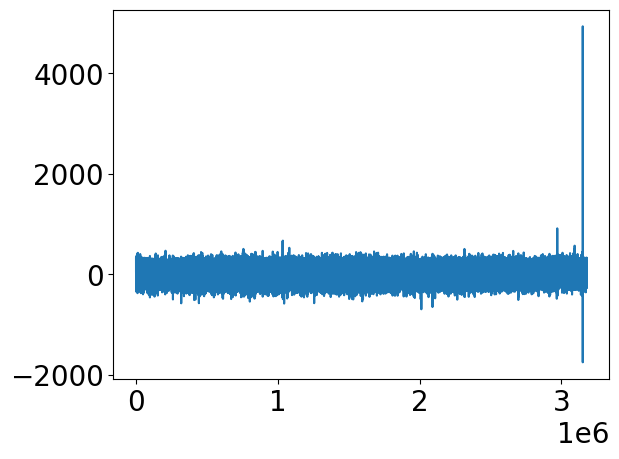

In [57]:
plt.plot(LFP_TRACES_DF["BLA_lfp_trace"].iloc[0])

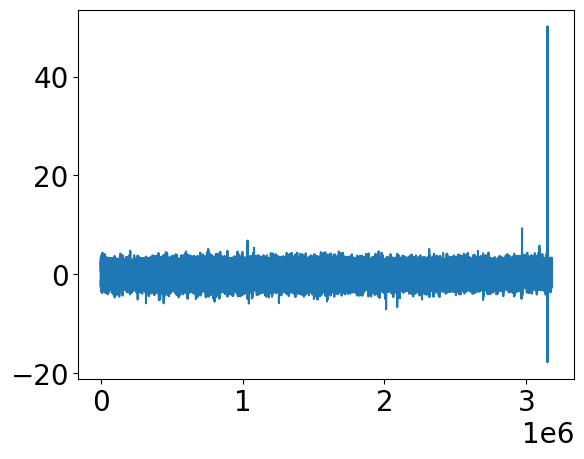

In [58]:
plt.plot(LFP_TRACES_DF["BLA_lfp_RMS"].iloc[0])

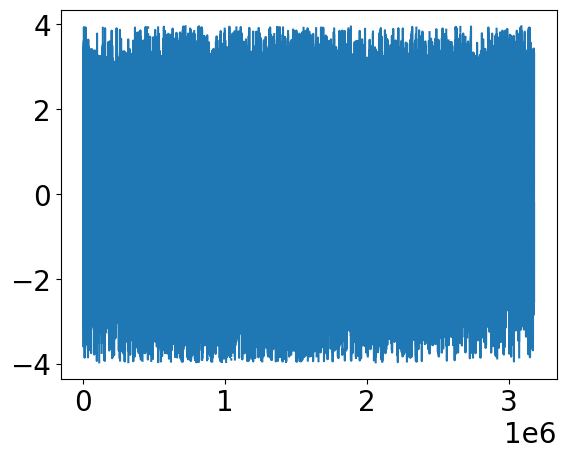

In [59]:
plt.plot(LFP_TRACES_DF["BLA_lfp_RMS_filtered"].iloc[0])

## Calculating phase of signals

In [60]:
from scipy.signal import butter, filtfilt, hilbert

- Filtering for theta and gamma

In [61]:
RMS_columns = [col for col in LFP_TRACES_DF if "RMS" in col and "filtered" not in col]

In [62]:
fs = 1000
order=4

In [63]:
freq_band = [4, 12]
b, a = butter(order, freq_band, fs=fs, btype='band')

In [64]:
for col in RMS_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_theta_band".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: filtfilt(b, a, x, padtype=None).astype(np.float32))

vHPC_lfp_RMS
BLA_lfp_RMS
LH_lfp_RMS
MD_lfp_RMS
mPFC_lfp_RMS


In [65]:
freq_band = [30, 50]
b, a = butter(order, freq_band, fs=fs, btype='band')

In [66]:
for col in RMS_columns:
    print(col)
    brain_region = col.split("_")[0]
    updated_column = "{}_gamma_band".format(brain_region)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: filtfilt(b, a, x, padtype=None).astype(np.float32))

vHPC_lfp_RMS
BLA_lfp_RMS
LH_lfp_RMS
MD_lfp_RMS
mPFC_lfp_RMS


- Calculating the phase

In [67]:
band_columns = [col for col in LFP_TRACES_DF if "band" in col]

In [68]:
band_columns

['vHPC_theta_band',
 'BLA_theta_band',
 'LH_theta_band',
 'MD_theta_band',
 'mPFC_theta_band',
 'vHPC_gamma_band',
 'BLA_gamma_band',
 'LH_gamma_band',
 'MD_gamma_band',
 'mPFC_gamma_band']

In [69]:
for col in band_columns:
    print(col)
    brain_region = col.replace("_band", "")
    updated_column = "{}_phase".format(brain_region)
    print(updated_column)
    LFP_TRACES_DF[updated_column] = LFP_TRACES_DF[col].apply(lambda x: np.angle(hilbert(x), deg=False))

vHPC_theta_band
vHPC_theta_phase
BLA_theta_band
BLA_theta_phase
LH_theta_band
LH_theta_phase
MD_theta_band
MD_theta_phase
mPFC_theta_band
mPFC_theta_phase
vHPC_gamma_band
vHPC_gamma_phase
BLA_gamma_band
BLA_gamma_phase
LH_gamma_band
LH_gamma_phase
MD_gamma_band
MD_gamma_phase
mPFC_gamma_band
mPFC_gamma_phase


In [70]:
LFP_TRACES_DF[col]

0     [-0.073652945, -0.027648753, 0.023473203, 0.07...
1     [-0.073652945, -0.027648753, 0.023473203, 0.07...
2     [-0.10603527, -0.11340957, -0.11593773, -0.113...
3     [-0.10603527, -0.11340957, -0.11593773, -0.113...
4     [-0.060700476, -0.11583101, -0.16058828, -0.19...
5     [-0.060700476, -0.11583101, -0.16058828, -0.19...
6     [0.10086174, 0.10749034, 0.10687582, 0.0987401...
7     [0.10086174, 0.10749034, 0.10687582, 0.0987401...
8     [0.0702091, 0.05466633, 0.03668893, 0.01727806...
9     [0.0702091, 0.05466633, 0.03668893, 0.01727806...
10    [-0.35048875, -0.32354048, -0.27675727, -0.212...
11    [-0.35048875, -0.32354048, -0.27675727, -0.212...
12    [-0.1007646, -0.08146265, -0.05295461, -0.0165...
13    [-0.1007646, -0.08146265, -0.05295461, -0.0165...
14    [-0.1857664, -0.120168306, -0.04169256, 0.0444...
15    [-0.1857664, -0.120168306, -0.04169256, 0.0444...
16    [-0.25569814, -0.21503006, -0.15813461, -0.088...
17    [-0.25569814, -0.21503006, -0.15813461, -0

## Coherence Calculation

- Getting the trace column pairs

In [71]:
brain_region_pairs = generate_pairs(sorted(input_columns))
brain_region_pairs = sorted(brain_region_pairs)


In [72]:
brain_region_pairs

[('BLA_lfp_RMS_filtered', 'LH_lfp_RMS_filtered'),
 ('BLA_lfp_RMS_filtered', 'MD_lfp_RMS_filtered'),
 ('BLA_lfp_RMS_filtered', 'mPFC_lfp_RMS_filtered'),
 ('BLA_lfp_RMS_filtered', 'vHPC_lfp_RMS_filtered'),
 ('LH_lfp_RMS_filtered', 'MD_lfp_RMS_filtered'),
 ('LH_lfp_RMS_filtered', 'mPFC_lfp_RMS_filtered'),
 ('LH_lfp_RMS_filtered', 'vHPC_lfp_RMS_filtered'),
 ('MD_lfp_RMS_filtered', 'mPFC_lfp_RMS_filtered'),
 ('MD_lfp_RMS_filtered', 'vHPC_lfp_RMS_filtered'),
 ('mPFC_lfp_RMS_filtered', 'vHPC_lfp_RMS_filtered')]

## Coherece Calculation

- Calculating the coherence

In [84]:
for region_1, region_2 in brain_region_pairs:
    # Define base name for pair
    pair_base_name = f"{region_1.split('_')[0]}_{region_2.split('_')[0]}"
    print(pair_base_name)

    try:
        # Define column names
        multitaper_col = f"{pair_base_name}_coherence_multitaper"
        connectivity_col = f"{pair_base_name}_coherence_connectivity"
        frequencies_col = f"{pair_base_name}_coherence_frequencies"
        coherence_col = f"{pair_base_name}_coherence_all_frequencies_all_windows"

        index_to_multitaper = {}
        index_to_connectivity = {}
        index_to_frequencies = {}
        index_to_coherence = {}

        for index, row in LFP_TRACES_DF.iterrows():
            index_to_multitaper[index] = Multitaper(
                time_series=np.array([row[region_1], row[region_2]]).T, 
                sampling_frequency=RESAMPLE_RATE, 
                time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT, 
                time_window_step=TIME_WINDOW_STEP, 
                time_window_duration=TIME_WINDOW_DURATION
            )
            print(index)
            index_to_connectivity[index] = Connectivity.from_multitaper(index_to_multitaper[index])
            index_to_frequencies[index] = index_to_connectivity[index].frequencies
            index_to_coherence[index] = index_to_connectivity[index].coherence_magnitude()[:,:,0,1]

        LFP_TRACES_DF[frequencies_col] = LFP_TRACES_DF.index.to_series().map(index_to_frequencies)
        LFP_TRACES_DF[coherence_col] = LFP_TRACES_DF.index.to_series().map(index_to_coherence)
        LFP_TRACES_DF[coherence_col] = LFP_TRACES_DF[coherence_col].apply(lambda x: x.astype(np.float32))

    except Exception as e: 
        print(e)

    # Drop temporary columns
    LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[multitaper_col, connectivity_col], errors="ignore")

BLA_LH
0
1
2
3
4
5
6
7
8
9
Out of memory allocating 608,544,256 bytes (allocated so far: 11,080,341,504 bytes).
BLA_MD
0
1
2


KeyboardInterrupt: 

In [73]:
for region_1, region_2 in brain_region_pairs:
    # Define base name for pair
    pair_base_name = f"{region_1.split('_')[0]}_{region_2.split('_')[0]}"
    print(pair_base_name)

    try:
        # Define column names
        multitaper_col = f"{pair_base_name}_coherence_multitaper"
        connectivity_col = f"{pair_base_name}_coherence_connectivity"
        frequencies_col = f"{pair_base_name}_coherence_frequencies"
        coherence_col = f"{pair_base_name}_coherence_all_frequencies_all_windows"

        # Apply Multitaper function
        LFP_TRACES_DF[multitaper_col] = LFP_TRACES_DF.apply(
            lambda x: Multitaper(
                time_series=np.array([x[region_1], x[region_2]]).T, 
                sampling_frequency=RESAMPLE_RATE, 
                time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT, 
                time_window_step=TIME_WINDOW_STEP, 
                time_window_duration=TIME_WINDOW_DURATION
            ), 
            axis=1
        )

        # Apply Connectivity function
        LFP_TRACES_DF[connectivity_col] = LFP_TRACES_DF[multitaper_col].apply(
            lambda x: Connectivity.from_multitaper(x)
        )

        # Apply frequencies and coherence functions
        LFP_TRACES_DF[frequencies_col] = LFP_TRACES_DF[connectivity_col].apply(
            lambda x: x.frequencies
        )
        LFP_TRACES_DF[coherence_col] = LFP_TRACES_DF[connectivity_col].apply(
            lambda x: x.coherence_magnitude()[:,:,0,1]
        )

        LFP_TRACES_DF[coherence_col] = LFP_TRACES_DF[coherence_col].apply(lambda x: x.astype(np.float32))

    except Exception as e: 
        print(e)

    # Drop temporary columns
    LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[multitaper_col, connectivity_col], errors="ignore")

BLA_LH
Out of memory allocating 612,576,256 bytes (allocated so far: 11,058,372,096 bytes).
BLA_MD
Out of memory allocating 612,576,256 bytes (allocated so far: 11,058,372,096 bytes).
BLA_mPFC
Out of memory allocating 612,576,256 bytes (allocated so far: 11,058,372,096 bytes).
BLA_vHPC
Out of memory allocating 612,576,256 bytes (allocated so far: 11,058,372,096 bytes).
LH_MD
Out of memory allocating 612,576,256 bytes (allocated so far: 11,058,372,096 bytes).
LH_mPFC
Out of memory allocating 612,576,256 bytes (allocated so far: 11,058,372,096 bytes).
LH_vHPC
Out of memory allocating 612,576,256 bytes (allocated so far: 11,058,372,096 bytes).
MD_mPFC
Out of memory allocating 612,576,256 bytes (allocated so far: 11,058,372,096 bytes).
MD_vHPC
Out of memory allocating 612,576,256 bytes (allocated so far: 11,058,372,096 bytes).
mPFC_vHPC
Out of memory allocating 612,576,256 bytes (allocated so far: 11,058,372,096 bytes).


In [78]:
LFP_TRACES_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,notes,session_path,recording,current_subject,...,BLA_theta_phase,LH_theta_phase,MD_theta_phase,mPFC_theta_phase,vHPC_gamma_phase,BLA_gamma_phase,LH_gamma_phase,MD_gamma_phase,mPFC_gamma_phase,coherence_timestamps
0,NaN,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[-2.334019, -1.9927528, -1.9034189, -1.7969302...","[-2.4721982, -2.0628796, -1.9708004, -1.852214...","[-2.598095, -2.1275039, -2.0337176, -1.9035088...","[-2.4334762, -2.04466, -1.9542742, -1.8397615,...","[-2.1064563, -1.4880958, -1.1023823, -0.809092...","[-1.7656207, -1.3221099, -0.9771053, -0.704203...","[3.1384287, -2.1446424, -1.7603616, -1.3851118...","[-3.0306644, -2.0574017, -1.6692585, -1.313524...","[-2.5887551, -1.7770386, -1.4036323, -1.106262...","[10000, 20000, 30000, 40000, 50000, 60000, 700..."
1,NaN,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-1_t6b6_merged,3.1,...,"[-2.334019, -1.9927528, -1.9034189, -1.7969302...","[-2.4721982, -2.0628796, -1.9708004, -1.852214...","[-2.598095, -2.1275039, -2.0337176, -1.9035088...","[-2.4334762, -2.04466, -1.9542742, -1.8397615,...","[-2.1064563, -1.4880958, -1.1023823, -0.809092...","[-1.7656207, -1.3221099, -0.9771053, -0.704203...","[3.1384287, -2.1446424, -1.7603616, -1.3851118...","[-3.0306644, -2.0574017, -1.6692585, -1.313524...","[-2.5887551, -1.7770386, -1.4036323, -1.106262...","[10000, 20000, 30000, 40000, 50000, 60000, 700..."
2,NaN,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 74], [1272, 1471], [3268, 3469], [4466, 4...","[[0, 74], [152, 157], [252, 305], [305, 323], ...","[[0, 74], [160, 225], [254, 257], [257, 279], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.1....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[2.777857, -2.8048103, -2.7293303, -2.4831357,...","[2.6830528, -2.927227, -2.8598695, -2.6025956,...","[2.7793484, -2.7970326, -2.719044, -2.4694462,...","[2.7433667, -2.8429945, -2.769275, -2.5160036,...","[2.267583, 2.6921847, 2.8533244, -3.1335492, -...","[2.224765, 2.616535, 2.7845728, 3.0693748, -3....","[2.3251767, 2.7912498, 2.93496, -3.0425863, -2...","[2.2850137, 2.7242794, 2.8865585, -3.093528, -...","[2.422544, 2.9823062, 3.1248415, -2.8174012, -...","[10000, 20000, 30000, 40000, 50000, 60000, 700..."
3,NaN,20240320_142408_alone_comp_subj_3-1_and_3-3,"[[0, 75], [1273, 1472], [3269, 3470], [4467, 4...","[[0, 75], [153, 158], [252, 306], [306, 324], ...","[[0, 75], [161, 226], [255, 258], [258, 280], ...",20240320_142408_alone_comp_subj_3-1_and_3-3.2....,NaN,/scratch/back_up/reward_competition_extention/...,20240320_142408_alone_comp_subj_3-3_t5b5_merged,3.3,...,"[2.777857, -2.8048103, -2.7293303, -2.4831357,...","[2.6830528, -2.927227, -2.8598695, -2.6025956,...","[2.7793484, -2.7970326, -2.719044, -2.4694462,...","[2.7433667, -2.8429945, -2.769275, -2.5160036,...","[2.267583, 2.6921847, 2.8533244, -3.1335492, -...","[2.224765, 2.616535, 2.7845728, 3.0693748, -3....","[2.3251767, 2.7912498, 2.93496, -3.0425863, -2...","[2.2850137, 2.7242794, 2.8865585, -3.093528, -...","[2.422544, 2.9823062, 3.1248415, -2.8174012, -...","[10000, 20000, 30000, 40000, 50000, 60000, 700..."
4,NaN,20240320_171038_alone_comp_subj_4-2_and_4-3,"[[0, 79], [1276, 1477], [3272, 3473], [4470, 4...","[[0, 79], [84, 92], [92, 132], [145, 175], [25...

- Getting the timestamps of the coherence

In [74]:
LFP_TRACES_DF["coherence_timestamps"] = LFP_TRACES_DF["lfp_timestamps"].apply(lambda x: x[(RESAMPLE_RATE//2):(-RESAMPLE_RATE//2):(RESAMPLE_RATE//2)])


- Making sure that the timestamps for coherence makes sense with shape and values

In [75]:
LFP_TRACES_DF["coherence_timestamps"].head().apply(lambda x: x.shape)

0    (6358,)
1    (6358,)
2    (6358,)
3    (6358,)
4    (6437,)
Name: coherence_timestamps, dtype: object

In [76]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_all_frequencies_all_windows" in col][0]].iloc[0].shape

IndexError: list index out of range

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "lfp_timestamps" in col][0]].iloc[0]

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_timestamps" in col][0]].iloc[0]

- Checking if the right frequencies are being used

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_frequencies" in col]].head()

In [ ]:
LFP_TRACES_DF["coherence_calculation_frequencies"] = LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "coherence_frequencies" in col][0]].copy()

- Dropping unnecessary columns

In [ ]:
LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[col for col in LFP_TRACES_DF.columns if "coherence_frequencies" in col], errors="ignore")

In [ ]:
LFP_TRACES_DF.head()

# Calculate Granger's

In [ ]:
for region_1, region_2 in brain_region_pairs:
    # Define base name for pair
    region_1_base_name = region_1.split('_')[0]
    region_2_base_name = region_2.split('_')[0]

    pair_base_name = f"{region_1_base_name}_{region_2_base_name}"
    print(pair_base_name)

    try:
        # Define column names
        multitaper_col = f"{pair_base_name}_granger_multitaper"
        connectivity_col = f"{pair_base_name}_granger_connectivity"
        frequencies_col = f"{pair_base_name}_granger_frequencies"
        granger_1_2_col = f"{region_1_base_name}_{region_2_base_name}_granger_all_frequencies_all_windows"
        granger_2_1_col = f"{region_2_base_name}_{region_1_base_name}_granger_all_frequencies_all_windows"

        # Apply Multitaper function
        LFP_TRACES_DF[multitaper_col] = LFP_TRACES_DF.apply(
            lambda x: Multitaper(
                time_series=np.array([x[region_1], x[region_2]]).T, 
                sampling_frequency=RESAMPLE_RATE, 
                time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT, 
                time_window_step=TIME_WINDOW_STEP, 
                time_window_duration=TIME_WINDOW_DURATION
            ), 
            axis=1
        )
    
        # Apply Connectivity function
        LFP_TRACES_DF[connectivity_col] = LFP_TRACES_DF[multitaper_col].apply(
            lambda x: Connectivity.from_multitaper(x)
        )

        # Apply frequencies and granger functions
        LFP_TRACES_DF[frequencies_col] = LFP_TRACES_DF[connectivity_col].apply(
            lambda x: x.frequencies
        )
        
        LFP_TRACES_DF[granger_1_2_col] = LFP_TRACES_DF[connectivity_col].apply(
            lambda x: x.pairwise_spectral_granger_prediction()[:,:,0,1]
        )

        LFP_TRACES_DF[granger_2_1_col] = LFP_TRACES_DF[connectivity_col].apply(
            lambda x: x.pairwise_spectral_granger_prediction()[:,:,1,0]
        )

        LFP_TRACES_DF[granger_1_2_col] = LFP_TRACES_DF[granger_1_2_col].apply(lambda x: x.astype(np.float32))
        LFP_TRACES_DF[granger_2_1_col] = LFP_TRACES_DF[granger_2_1_col].apply(lambda x: x.astype(np.float32))
        
    except Exception as e: 
        print(e)

    # Drop temporary columns
    LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[multitaper_col, connectivity_col], errors="ignore")

- Getting the timestamps of the granger

In [ ]:
LFP_TRACES_DF["granger_timestamps"] = LFP_TRACES_DF["lfp_timestamps"].apply(lambda x: x[(RESAMPLE_RATE//2):(-RESAMPLE_RATE//2):(RESAMPLE_RATE//2)])


- Making sure that the timestamps for granger makes sense with shape and values

In [ ]:
LFP_TRACES_DF["granger_timestamps"].head().apply(lambda x: x.shape)

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_all_frequencies_all_windows" in col][0]].iloc[0].shape

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "lfp_timestamps" in col][0]].iloc[0]

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_timestamps" in col][0]].iloc[0]

- Checking if the right frequencies are being used

In [ ]:
LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_frequencies" in col]].head()

In [ ]:
LFP_TRACES_DF["granger_calculation_frequencies"] = LFP_TRACES_DF[[col for col in LFP_TRACES_DF.columns if "granger_frequencies" in col][0]].copy()

- Dropping unnecessary columns

In [ ]:
LFP_TRACES_DF = LFP_TRACES_DF.drop(columns=[col for col in LFP_TRACES_DF.columns if "granger_frequencies" in col], errors="ignore")

In [ ]:
LFP_TRACES_DF.head()

In [ ]:
LFP_TRACES_DF.columns

In [ ]:
# LFP_TRACES_DF.to_pickle("./proc/rce2_spectral_granger.pkl")
LFP_TRACES_DF.to_pickle("./proc/{}_02_full_spectral.pkl".format(OUTPUT_PREFIX))
# LFP_TRACES_DF.to_pickle("/blue/npadillacoreano/ryoi360/projects/reward_comp/final_proc/rce_pilot_2_02_spectral_granger.pkl")

In [ ]:
raise ValueError()